# Immigrants in CA - JTF
#### A repo containing the code and data to reproduce the numbers in PPIC's Immigrants in CA JTF

<details>
    <summary><strong>Goal</strong></summary>
    The goal of this notebook is to reproduce the 2nd chart in our Immigrants in CA JTF
</details>

<details>
    <summary><strong>Context</strong></summary>
    We've downloaded raw data from <strong><i>ipums.org</i></strong>.
    It includes ACS 2004-2018 and the variables:
    <ul>
        <li>statefip</li>
        <li>bpld</li>
        <li>citizen</li>
        <li>yrsusa2</li>
        <li>migplac1</li>
    </ul>
    plus the typical variables included by IPUMS (perwt, hhwt, gq, etc).
</details>

In [1]:
import pandas as pd
import gzip
from pathlib import Path
from tools import tree
from datetime import datetime as dt
today = dt.today().strftime("%d-%b-%y")

today

'09-Jan-20'

In [2]:
RAW_DATA = Path("../data/raw/")
INTERIM_DATA = Path("../data/interim/")
PROCESSED_DATA = Path("../data/processed/")
FINAL_DATA = Path("../data/final/")

In [3]:
tree(RAW_DATA)

+ ..\data\raw
    + usa_00072.dta.gz


In [4]:
with gzip.open(RAW_DATA / 'usa_00072.dta.gz', 'r') as file:
    data = pd.read_stata(file)

In [5]:
data.head()

,year,sample,serial,cbserial,hhwt,cluster,statefip,strata,gq,pernum,perwt,age,bpl,bpld,citizen,yrsusa2,migplac1
0,2004,2004 acs,23712,NaN,208,2.004000e+12,california,6,households under 1970 definition,1,220,37,nebraska,nebraska,n/a,n/a,n/a
1,2004,2004 acs,23712,NaN,208,2.004000e+12,california,6,households under 1970 definition,2,222,14,california,california,n/a,n/a,n/a
2,2004,2004 acs,23712,NaN,208,2.004000e+12,california,6,households under 1970 definition,3,221,12,california,california,n/a,n/a,n/a
3,2004,2004 acs,23712,NaN,208,2.004000e+12,california,6,households under 1970 definition,4,220,47,indiana,indiana,n/a,n/a,n/a
4,2004,2004 acs,23713,NaN,244,2.004000e+12,california,6,households under 1970 definition,1,258,29,florida,florida,n/a,n/a,n/a


In [6]:
columns_of_interest = ['year', 'perwt', 'statefip', 'migplac1', 'citizen', 'bpld']

In [7]:
working_data = data[columns_of_interest].copy()

In [8]:
for index,category in enumerate(working_data['migplac1'].cat.categories):
    print(f"{index}.\t{category}")

0.	n/a
1.	alabama
2.	alaska
3.	arizona
4.	arkansas
5.	california
6.	colorado
7.	connecticut
8.	delaware
9.	district of columbia
10.	florida
11.	georgia
12.	hawaii
13.	idaho
14.	illinois
15.	indiana
16.	iowa
17.	kansas
18.	kentucky
19.	louisiana
20.	maine
21.	maryland
22.	massachusetts
23.	michigan
24.	minnesota
25.	mississippi
26.	missouri
27.	montana
28.	nebraska
29.	nevada
30.	new hampshire
31.	new jersey
32.	new mexico
33.	new york
34.	north carolina
35.	north dakota
36.	ohio
37.	oklahoma
38.	oregon
39.	pennsylvania
40.	rhode island
41.	south carolina
42.	south dakota
43.	tennessee
44.	texas
45.	utah
46.	vermont
47.	virginia
48.	washington
49.	west virginia
50.	wisconsin
51.	wyoming
52.	guam
53.	puerto rico
54.	other us possessions
55.	canada
56.	mexico
57.	el salvador
58.	guatemala
59.	honduras
60.	central america, nec
61.	cuba
62.	dominican republic
63.	haiti
64.	jamaica
65.	other caribbean and north america
66.	brazil
67.	chile
68.	colombia
69.	ecuador
70.	peru
71.	venezuela
72.	

In [9]:
working_data['citizen'].cat.categories

Index(['n/a', 'born abroad of american parents', 'naturalized citizen',
       'not a citizen'],
      dtype='object')

In [10]:
mask_state = working_data['statefip'] == 'california'
mask_citizen = working_data['citizen'] != 'n/a'
mask_newlyarrivals = (working_data['migplac1'] >= 'canada') 

mask_latam = (working_data['migplac1'] >= 'mexico') & (working_data['migplac1'] <= 'south america, nec')
mask_asia = (working_data['migplac1'] >= 'china') & (working_data['migplac1'] <= 'asia, nec')

In [11]:
california = working_data[mask_state & mask_newlyarrivals & mask_citizen].copy()

In [12]:
california.loc[mask_latam, 'place of origin'] = 'Latin America'
california.loc[mask_asia, 'place of origin'] = 'Asia'
california['place of origin'].fillna('Other', inplace = True)

In [13]:
california.head()

,year,perwt,statefip,migplac1,citizen,bpld,place of origin
696,2004,849,california,mexico,not a citizen,mexico,Latin America
697,2004,668,california,mexico,not a citizen,mexico,Latin America
1045,2004,169,california,canada,born abroad of american parents,canada,Other
1219,2004,292,california,japan,not a citizen,japan,Asia
1252,2004,236,california,other northern or eastern europe,not a citizen,vietnam,Other


In [14]:
time_series = california.groupby(['year', 'place of origin']).agg({'perwt': 'sum'})
time_series.reset_index(inplace = True)

In [15]:
time_series.head()

,year,place of origin,perwt
0,2004,Asia,76102.0
1,2004,Latin America,142872.0
2,2004,Other,24440.0
3,2005,Asia,89655.0
4,2005,Latin America,124924.0


# Chart

In [16]:
import altair as alt

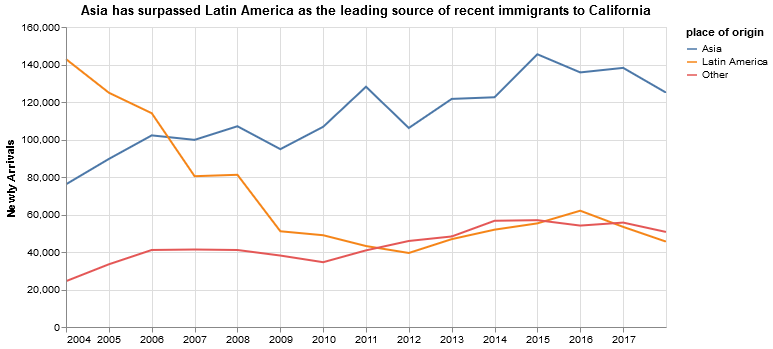

In [17]:
alt.Chart(time_series).mark_line().encode(
    x = alt.X('year:T', axis = alt.Axis(title = "")),
    y = alt.Y('perwt:Q', axis = alt.Axis(title = "Newly Arrivals")),
    color = alt.Color("place of origin:N",),
).properties(
    title = "Asia has surpassed Latin America as the leading source of recent immigrants to California",
    width = 600
)

[**Other notebook**](00_bullet_4_text.ipynb)